**Burgers equation with residual-based adaptive refinement**

Retyped by Theodoret Putra Agatho on 6 Aug. 2023

[Source](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/burgers.rar.html)

**ReadMe!**
Before running this notebook in google colab, it's required to upload "Burgers.npz" file in google colab files section.

In [31]:
pip install deepxde

**Problem setup**

We will solve a Burgers equation:

\begin{align}
        \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = v \frac{\partial ^2 u}{\partial x^2}, x \in [-1, 1], t \in [0,1]
    \end{align}

with the Dirichlet boundary conditions and initial conditons

\begin{align}
        u(-1, t) = u(1, t) = 0, u(x, 0) = -\text{sin}(\pi x).
    \end{align}

The reference solution is [here](https://github.com/lululxvi/deepxde/blob/master/examples/dataset/Burgers.npz)

**Implementation**

This description goes through the implementation of a solver for the above described Burgers equation step-by-step.

First, the DeepXDE and TensorFlow(`tf`) modules are imported:

In [5]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

We begin by defining a computational geomemtry and time domain. We can use a built-in class `Interval` and `TimeDomain` and we combine both the domains using `GeometryXTime` as follows

In [3]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Next, we express the PDE residual of the Burgers equation:

In [4]:
def pde(x, y):
  dy_x = dde.grad.jacobian(y, x, i=0, j=0)
  dy_t = dde.grad.jacobian(y, x, i=0, j=1)
  dy_xx = dde.grad.hessian(y, x, i=0, j=0)
  return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

The first argument to `pde` is 2-dimensional vector where the first componenent(`x[:,0]`) is the $x$-coordinate and the second componenet(`x[:,1]`) is the $t$-coordinate. The second argument is the network output, i.e., the solution $u(x, t)$, bbut here we use `y` as the name of the variable.

Next, we consider the boundary/initial condition. `on_boundary` is chosen here to use the whole boundary of the computational domain in considered as the boundary condition. We include the `geomtime` space, time geometry created above and `on_boundary` as the BCs in the `DirichletBC` function of DeepXDE. We also define `IC` whhich is the initial conditon for the burgers equation and we use the computational domain, initial function, and `on_initial` to specifty the IC.

In [12]:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

Now, we have specified the geometry, PDE residual, and boundary/initial condition. We thend efine the `TimePDE` problem as

In [13]:
data = dde.data.TimePDE(geomtime, pde, [bc, ic],
                        num_domain=2500, num_boundary=100, num_initial=100)

The number 2500 is the number of training residual points sampled inside the domain, and the number 100 is the number of training points sampled on the boundary. We also include 100 initial residual points for the initial conditions..

Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 20:

In [14]:
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

Now, we have the PDE problem and the network. We build a `Model` and choose the optimizer and learning rate:

In [15]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.079361 s

'compile' took 0.627169 s



We then train the model for 10000 iterations:

In [16]:
losshistory, train_state = model.train(iterations=10000)

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.85e-01, 2.02e-01, 2.76e-01]    [1.85e-01, 2.02e-01, 2.76e-01]    []  
1000      [4.21e-02, 1.06e-03, 5.72e-02]    [4.21e-02, 1.06e-03, 5.72e-02]    []  
2000      [2.95e-02, 1.54e-04, 3.73e-02]    [2.95e-02, 1.54e-04, 3.73e-02]    []  
3000      [1.10e-02, 1.44e-04, 7.69e-03]    [1.10e-02, 1.44e-04, 7.69e-03]    []  
4000      [4.91e-03, 5.81e-05, 3.81e-03]    [4.91e-03, 5.81e-05, 3.81e-03]    []  
5000      [3.25e-03, 2.92e-05, 2.90e-03]    [3.25e-03, 2.92e-05, 2.90e-03]    []  
6000      [2.62e-03, 1.78e-05, 2.36e-03]    [2.62e-03, 1.78e-05, 2.36e-03]    []  
7000      [2.20e-03, 1.30e-05, 1.96e-03]    [2.20e-03, 1.30e-05, 1.96e-03]    []  
8000      [1.83e-03, 6.88e-06, 1.64e-03]    [1.83e-03, 6.88e-06, 1.64e-03]    []  
9000      [1.59e-03, 4.92e-06, 1.37e-03]    [1.59e-03, 4.92e-06, 1.37e-03]    []  
10000     [3.21e-03, 1.50e-05, 1.13e-03]    [3.21e-03, 1.50e-

After we train the network using Adam, we continue to train the network using L-BFGS to achieve a smaller loss:

In [17]:
model.compile("L-BFGS-B")
losshisotry, train_state = model.train()

Compiling model...
'compile' took 0.362381 s

Training model...

Step      Train loss                        Test loss                         Test metric
10000     [3.21e-03, 1.50e-05, 1.13e-03]    [3.21e-03, 1.50e-05, 1.13e-03]    []  
11000     [2.52e-04, 7.65e-07, 1.96e-04]    [2.52e-04, 7.65e-07, 1.96e-04]        
12000     [1.13e-04, 4.54e-07, 4.57e-05]    [1.13e-04, 4.54e-07, 4.57e-05]        
13000     [5.77e-05, 1.57e-07, 1.60e-05]    [5.77e-05, 1.57e-07, 1.60e-05]        
14000     [3.38e-05, 8.97e-08, 8.21e-06]    [3.38e-05, 8.97e-08, 8.21e-06]        
15000     [2.19e-05, 5.88e-08, 3.58e-06]    [2.19e-05, 5.88e-08, 3.58e-06]        
16000     [1.49e-05, 8.42e-08, 1.42e-06]    [1.49e-05, 8.42e-08, 1.42e-06]        
17000     [9.55e-06, 5.76e-08, 7.55e-07]    [9.55e-06, 5.76e-08, 7.55e-07]        
18000     [6.69e-06, 1.76e-08, 5.47e-07]    [6.69e-06, 1.76e-08, 5.47e-07]        
18387     [6.20e-06, 1.66e-08, 4.68e-07]    [6.20e-06, 1.66e-08, 4.68e-07]    []  

Best model at 

Because we only use 2500 residual points for training, the accuracy is low. Next, we improve the accuracy by the residual-based adaptive refinement (RAR) method. Because the Burgers equation has a sharp front, intuitively, we should put more points near the sharp front. First, we randomly generate 100000 points from our domain to calculate the PDE residual.

In [18]:
X = geomtime.random_points(100000)
err = 1

We will repeatedly add points while the mean residual is greater than 0.005. Each iteration, we use our model to generate ppredictions for inputs in `x` and compute the absolute values of the errors. We then print the mean residual. Next, we find the points where the residual is greates and add these new points for training PDE loss. Furthermore, we dine a callback function to check whether the network converges. If there is significant improvement in the model's accuracy, as judged by the callback function, we contionue to train the model. As before, after we train the network using Adam, we continue to train the network using L-BFGS to achieve a smaller loss:

In [21]:
while err > 0.005:
  f = model.predict(X, operator=pde)
  err_eq = np.absolute(f)
  err = np.mean(err_eq)
  print("Mean residual: %.3e" % (err))

  x_id = np.argmax(err_eq)
  print("Adding new point:", X[x_id], "\n")
  data.add_anchors(X[x_id])
  early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
  model.compile("adam", lr=1e-3)
  model.train(iterations=10000, disregard_previous_best=True, callbacks=[early_stopping])
  model.compile("L-BFGS")
  losshistory, train_state = model.train()

Finally, we display a graph depicitng train loss and test loss over time, along with a graph displaying the predicted solution to the PDE.

In [29]:
def gen_testdata():
  data = np.load("Burgers.npz")
  t, x, exact = data["t"], data["x"], data["usol"].T
  xx, tt = np.meshgrid(x, t)
  X = np.vstack((np.ravel(xx), np.ravel(tt))).T
  y = exact.flatten()[:, None]
  return X, y

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


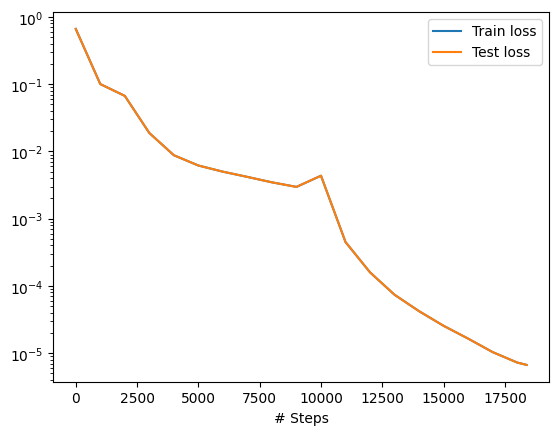

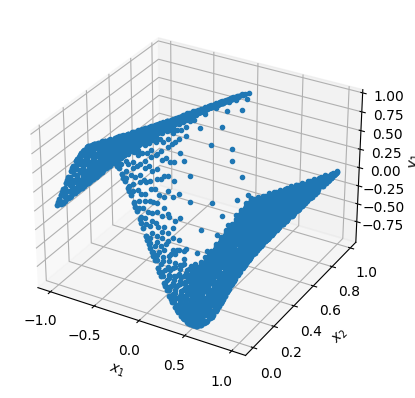

L2 relative error: 0.005515321384008901


In [30]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X, y_true = gen_testdata()
y_pred = model.predict(X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))